# Data exploration and pre-processing

## Data reading 

In [1]:
import nltk
import warnings
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS

In [2]:
np.random.seed(27) 
sns.set_style('white')
warnings.filterwarnings('ignore')

The dataset is a csv, where each line is a tweet.


In [3]:
tweets = pd.read_csv("../processed_tweet_data.csv")
tweets[:2]

created_at  \
0  Fri Jun 18 17:55:49 +0000 2021   
1  Fri Jun 18 17:55:59 +0000 2021   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="https://mobile.twitter.com" rel="nofo...   

                                       original_text  polarity  subjectivity  \
0  🚨Africa is "in the midst of a full-blown third...  0.166667      0.188889   
1  Dr Moeti is head of WHO in Africa, and one of ...  0.133333      0.455556   

  lang  favorite_count  retweet_count original_author  followers_count  \
0   en             548            612     ketuesriche              551   
1   en             195             92        Grid1949               66   

   friends_count possibly_sensitive hashtags  \
0            351              False       []   
1             92              False       []   

                                       user_mentions                place  
0  [{'screen_name': 'TelGlobalHealth', 'name': 'T...                 Mass  
1  [{'screen_name': 'globalhlthtwit', 'name': 'An...  Edinburgh, Scotland

## Pre-processing

All the methods I use to clean and normalize the data are defined in `clean_tweets_dataframe.py` file
so we start by importing that.

In [4]:
sys.path.append(os.path.abspath(os.path.join('..')))
from clean_tweets_dataframe import Clean_Tweets

In [5]:
ct = Clean_Tweets()

### Drop duplicate

First we try to drop duplicates if there are any in the dataset.

In [6]:
print(f"Shape of tweets before droping duplicates tweets {tweets.shape}")
tweets = ct.drop_duplicate(tweets)
print(f"Shape of tweets after droping duplicates tweets {tweets.shape}")


Shape of tweets before droping duplicates tweets (6532, 15)
Shape of tweets after droping duplicates tweets (6532, 15)


this indicates there aren't duplicate values in the data

### Clean original_text

Lets start by removing non english tweets


In [7]:
tweets = ct.remove_non_english_tweets(tweets)

Since we have droped non english tweets, we no longer need lang column.

In [8]:
tweets.drop(['lang'], axis=1, inplace=True)

Remove links

In [9]:
tweets = ct.remove_links(tweets)

Removing Punctuations, Numbers, and Special Characters

In [10]:
tweets = ct.remove_special_characters(tweets)

In [11]:
tweets.original_text[:3]

0     Africa is  in the midst of a full blown third...
1    Dr Moeti is head of WHO in Africa  and one of ...
2    Thank you  research note for creating this ama...
Name: original_text, dtype: object

### Hashtags

There are two types of hashtags in the dataset. 
1) those that are in hashtag column and 
2) those that are inside original-text.

We will clean both and puth theme in separate columns


In [12]:
tweets["hashtags"] = tweets["hashtags"].apply((lambda x: ct.get_element_from_json(x, 'text', '#')))
tweets["hashtags"][:3]

0                 []
1                 []
2    [#red4research]
Name: hashtags, dtype: object

In [13]:
tweets["hashtags"] = tweets["hashtags"].apply(ct.array_to_string)
tweets["hashtags"][:10]

0                              
1                              
2                 #red4research
3                              
4                              
5    #WeCanDoThis, #WeCanDoThis
6                              
7                              
8                              
9                      #Covid19
Name: hashtags, dtype: object

Hashtags in original_text

In [14]:
new_df = pd.DataFrame(columns=['hashtags'])
new_df['hashtags'] = tweets.original_text.apply(ct.find_hashtags)
new_df[:5]

hashtags
0        []
1        []
2    [#red]
3  [#Covid]
4        []

In [15]:
tweets["hashtags_in_tweets"] = new_df["hashtags"].apply(ct.array_to_string)
tweets["hashtags_in_tweets"][:10]

0                         
1                         
2                     #red
3                   #Covid
4                         
5     #WeCanDoThis, #COVID
6                         
7                         
8                         
9    #Covid, #DeltaVariant
Name: hashtags_in_tweets, dtype: object

### Screan Names

Screan names are usernames that are mentiond in original_text

In [16]:
tweets["screen_name"] = tweets["user_mentions"].apply(
    (lambda x: ct.get_element_from_json(x, 'screen_name', "@",)))
tweets["screen_name"][:3]

0       [@TelGlobalHealth, @TelGlobalHealth]
1                          [@globalhlthtwit]
2    [@NHSRDForum, @NHSRDForum, @NHSRDForum]
Name: screen_name, dtype: object

In [17]:
tweets["screen_name"] = tweets["screen_name"].apply(ct.array_to_string)
tweets["screen_name"][:3]


0       @TelGlobalHealth, @TelGlobalHealth
1                          @globalhlthtwit
2    @NHSRDForum, @NHSRDForum, @NHSRDForum
Name: screen_name, dtype: object

Now we have extracted screen_name from user_mentions, we can drop the collumn.

In [18]:
tweets.drop(['user_mentions'], axis=1, inplace=True)

### Device

Screan names are usernames that are mentiond in original_text

In [19]:
tweets["device"] = tweets["source"].apply(ct.get_device_name)
tweets["device"][:3]

0    Twitter for iPhone
1       Twitter Web App
2    Twitter for iPhone
Name: device, dtype: object

Now we have extracted the device name, we dont need source.

In [20]:
tweets.drop(['source'], axis=1, inplace=True)

### Turn all the text to lowercase


In [21]:
tweets = ct.to_lower(tweets)

### Missing values

In [22]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6532 entries, 0 to 6531
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          6532 non-null   object 
 1   original_text       6532 non-null   object 
 2   polarity            6532 non-null   float64
 3   subjectivity        6532 non-null   float64
 4   favorite_count      6532 non-null   int64  
 5   retweet_count       6532 non-null   int64  
 6   original_author     6532 non-null   object 
 7   followers_count     6532 non-null   int64  
 8   friends_count       6532 non-null   int64  
 9   possibly_sensitive  3618 non-null   object 
 10  hashtags            6532 non-null   object 
 11  place               4088 non-null   object 
 12  hashtags_in_tweets  6532 non-null   object 
 13  screen_name         6532 non-null   object 
 14  device              6532 non-null   object 
dtypes: float64(2), int64(4), object(9)
memory usage: 1.0+ M

In [23]:
print("The number of missing value(s): {}".format(tweets.isnull().sum().sum()))
print("Columons having columns value: {}".format( tweets.columns[tweets.isnull().any()]))

The number of missing value(s): 5358
Columons having columns value: Index(['possibly_sensitive', 'place'], dtype='object')


In [24]:
tweets["possibly_sensitive"].fillna(False, inplace=True) # assume its not sensative
tweets["place"].fillna(" ", inplace=True)

### Convert all the columns to correct data type

In [25]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6532 entries, 0 to 6531
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          6532 non-null   object 
 1   original_text       6532 non-null   object 
 2   polarity            6532 non-null   float64
 3   subjectivity        6532 non-null   float64
 4   favorite_count      6532 non-null   int64  
 5   retweet_count       6532 non-null   int64  
 6   original_author     6532 non-null   object 
 7   followers_count     6532 non-null   int64  
 8   friends_count       6532 non-null   int64  
 9   possibly_sensitive  6532 non-null   bool   
 10  hashtags            6532 non-null   object 
 11  place               6532 non-null   object 
 12  hashtags_in_tweets  6532 non-null   object 
 13  screen_name         6532 non-null   object 
 14  device              6532 non-null   object 
dtypes: bool(1), float64(2), int64(4), object(8)
memory usag

#### convert text columns to string

We choose `StringDtype` over `object` for this reasons:
- You can accidentally store a mixture of strings and non-strings in an object dtype array. It’s better to have a dedicated dtype.
- object dtype breaks dtype-specific operations like DataFrame.select_dtypes(). There isn’t a clear way to select just text while excluding non-text but still object-dtype columns.
- When reading code, the contents of an object dtype array is less clear than 'string'.

In [26]:
tweets = ct.convert_to_string(tweets)

Convert time to datetime

In [27]:
print(f"The first row created time before conversion {tweets.created_at[0]}")
tweets = ct.convert_to_datetime(tweets)
print(f"The first row created time after conversion {tweets.created_at[0]}")

The first row created time before conversion Fri Jun 18 17:55:49 +0000 2021
The first row created time after conversion 2021-06-18 17:55:49+00:00


Convert numeric values to number

In [28]:
tweets = ct.convert_to_numbers(tweets)

Convert possible_sansitive column to boolean

In [29]:
tweets = ct.convert_to_boolean(tweets)

Convert possible_sansitive column to boolean

In [30]:
tweets = ct.convert_to_numbers(tweets)

In [31]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6532 entries, 0 to 6531
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          6532 non-null   datetime64[ns, UTC]
 1   original_text       6532 non-null   string             
 2   polarity            6532 non-null   float64            
 3   subjectivity        6532 non-null   float64            
 4   favorite_count      6532 non-null   int64              
 5   retweet_count       6532 non-null   int64              
 6   original_author     6532 non-null   string             
 7   followers_count     6532 non-null   int64              
 8   friends_count       6532 non-null   int64              
 9   possibly_sensitive  6532 non-null   bool               
 10  hashtags            6532 non-null   string             
 11  place               6532 non-null   string             
 12  hashtags_in_tweets  6532 non-null 

### Finaly we will save cleaned data

In [32]:
tweets.to_csv(r'clean_tweets.csv', index=False, header=True)

## Data exploration 

### Rows and columns in the dataset

In [33]:
tweets = pd.read_csv("clean_tweets.csv")

In [34]:
print('Count of columns in the data is:  ', len(tweets.columns))
print('Count of rows in the data is:  ', len(tweets))

Count of columns in the data is:   15
Count of rows in the data is:   6532


### Users that made the tweets

In [35]:
tweets.groupby("original_author").size().agg( ['count', 'min', 'max', 'mean', 'median'])

count     5248.000000
min          1.000000
max        530.000000
mean         1.244665
median       1.000000
dtype: float64

From this we can observe the tweets were made by 5248 users. Most of them had made one tweet and 
one person had made 530 tweets.

In [36]:
twetter_users = tweets.groupby("original_author").size()
twetter_users.nlargest(5)

original_author
puneupdater        530
viralvideovlogs     45
signal__pump        27
who__india          27
rosenchild          11
dtype: int64

This indicates the person who made 530 tweets is an outlier. Maybe we can drop this columns because we don't want one person's opinion to influence our model.

### Devices from wich tweets are made

In [37]:
tweets.groupby("device").size().agg( ['count', 'min', 'max', 'mean', 'median'])

count       98.000000
min          1.000000
max       2071.000000
mean        66.653061
median       1.000000
dtype: float64

In [38]:
twetter_device = tweets.groupby("device").size()
twetter_device.nlargest(5)


device
twitter for android    2071
twitter for iphone     1982
twitter web app        1345
vaccine finder          530
twitter for ipad        267
dtype: int64

Most tweets were from mobile device. 

### Tweet sentiments

In [39]:
tweets["score"] = tweets["polarity"].apply(ct.polarity_category)
tweets.groupby("score")["polarity"].count()

score
negative    1277
neutral     1829
positive    3426
Name: polarity, dtype: int64

In [40]:
tweet_sent = tweets.groupby(['score']).sum()[["retweet_count", "favorite_count", "followers_count", "friends_count"]]
tweet_sent

retweet_count  favorite_count  followers_count  friends_count
score                                                                  
negative          88602          159704         10157572        1278012
neutral          326311          396722         36775025        2520950
positive         414183         1030171         60839857        7355421

We can observe positive tweets are more retweeted, liked and people with more followers and friends had made a positive tweet about covid 19.

In [41]:
tweets["subjectivity_score"] = tweets["subjectivity"].apply(
    ct.subjectivity_category)
tweets.groupby("subjectivity_score")["subjectivity"].count()

subjectivity_score
objective          3475
very objective     2143
very subjective     914
Name: subjectivity, dtype: int64

In [42]:
tweet_sent = tweets.groupby(['subjectivity_score']).sum(
)[["retweet_count", "favorite_count", "followers_count", "friends_count"]]
tweet_sent


retweet_count  favorite_count  followers_count  \
subjectivity_score                                                   
objective                  332364          878199         59508432   
very objective             450747          570888         42663775   
very subjective             45985          137510          5600247   

                    friends_count  
subjectivity_score                 
objective                 7049059  
very objective            3206532  
very subjective            898792

### Hashtags

In [75]:
tweets_df = pd.DataFrame(columns=['hashtags', 'hashtags_in_tweets'])
tweets_df['hashtags'] = tweets['hashtags'].apply(ct.string_to_array)
tweets_df['hashtags_in_tweets'] = tweets['hashtags_in_tweets'].apply(
    ct.string_to_array)
tweets_df[:4]

hashtags hashtags_in_tweets
0             None               None
1             None               None
2  [#red4research]             [#red]
3             None           [#covid]

In [76]:
tweets_df.dropna(inplace=True)
tweets_df[:4]

hashtags       hashtags_in_tweets
2                [#red4research]                   [#red]
5   [#wecandothis, #wecandothis]   [#wecandothis, #covid]
9                     [#covid19]  [#covid, #deltavariant]
10  [#wecandothis, #wecandothis]   [#wecandothis, #covid]

In [45]:
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in tweets_df.hashtags
     for hashtag in hashtags_list],
    columns=['hashtag'])
flattened_hashtags_df[:4]

hashtag
0  #red4research
1   #wecandothis
2   #wecandothis
3       #covid19

In [46]:
flattened_hashtags_df.value_counts()[:10]

hashtag      
#covid19         2081
#wecandothis      287
#coronavirus      122
#deltavariant      91
#uganda            88
#africa            82
#cuban             78
#china             55
#tanzania          54
#bihar             44
dtype: int64

In [47]:
flattened_hashtags_in_tweets_df = pd.DataFrame(
    [hashtag for hashtags_list in tweets_df.hashtags_in_tweets
     for hashtag in hashtags_list],
    columns=['hashtag'])

flattened_hashtags_in_tweets_df[:4]

hashtag
0          #red
1  #wecandothis
2        #covid
3        #covid

In [48]:
flattened_hashtags_in_tweets_df.value_counts()[:10]

hashtag          
#covid               2464
#vaccines             210
#africa               176
#coronavirus          158
#wecandothis          151
#deltavariant         121
#covidvaccination      71
#vaccine               68
#astrazeneca           52
#uganda                52
dtype: int64

### screen_names

In [49]:
tweets_df = pd.DataFrame(columns=['screen_name', ])
tweets_df['screen_name'] = tweets['screen_name'].apply(ct.string_to_array)
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   screen_name  5113 non-null   object
dtypes: object(1)
memory usage: 51.2+ KB


In [50]:
tweets_df.dropna(inplace=True)
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5113 entries, 0 to 6531
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   screen_name  5113 non-null   object
dtypes: object(1)
memory usage: 79.9+ KB


In [51]:
flattened_screen_name_df = pd.DataFrame(
    [hashtag for screen_name_list in tweets_df.screen_name
     for hashtag in screen_name_list],
    columns=['hashtag'])
flattened_screen_name_df[:4]

hashtag
0  @telglobalhealth
1  @telglobalhealth
2   @globalhlthtwit
3       @nhsrdforum

In [52]:
flattened_screen_name_df.value_counts()[:10]

hashtag         
@shawajason         715
@telglobalhealth    368
@cdcgov             237
@globalhlthtwit     206
@bogochisaac        194
@cdcdirector        143
@winnie_byanyima    121
@itranslate123      112
@moetitshidi         99
@drericding          95
dtype: int64

## Visualisations

We start visualization by converting polarity to 3 groups.

In [53]:
tweets["score"] = tweets["polarity"].apply(ct.polarity_category)

### Users that made the tweets


In [54]:
df = tweets.groupby(['original_author', 'score']
                    ).size().reset_index(name='counts')
px.histogram(df.nlargest(20, "counts"),
             x="original_author", y="counts", color="score")

This strengthens our earlier observation that one person's opinion influencing the model. One person have made almost half of the negative tweets, 530 from 1277.

In [55]:
df = tweets.groupby(['original_author', 'subjectivity_score']
                    ).size().reset_index(name='counts')
px.histogram(df.nlargest(20, "counts"),
             x="original_author", y="counts", color="subjectivity_score")


Most of our subjective tweets are from `puneupdater`.

### device

In [56]:
df = tweets.groupby(['device', 'score']
                    ).size().reset_index(name='counts')
px.histogram(df.nlargest(20, "counts"),
             x="device", y="counts", color="score")

Here we can see tweets coming from device name `vaccine finder` are all negative. What is interesting is tweets from this device are around 530, meaning there is no other user of this device. I don't think data from `puneupdater` is valid.

### Tweet sentiments

In [57]:
specs = [[{'type': 'domain'}, {'type': 'domain'}],
         [{'type': 'domain'}, {'type': 'domain'}]]
fig = make_subplots(rows=2, cols=2, specs=specs)

fig.add_trace(go.Pie(labels=tweets["score"],
                     values=tweets["retweet_count"], name='retweet_count',), 1, 1)
fig.add_trace(go.Pie(labels=tweets["score"],
                     values=tweets["favorite_count"], name='favorite_count',), 1, 2)
fig.add_trace(go.Pie(labels=tweets["score"],
                     values=tweets["followers_count"], name='followers_count',), 2, 1)
fig.add_trace(go.Pie(labels=tweets["score"],
                     values=tweets["friends_count"], name='friends_count',), 2, 2)
# Tune layout and hover info
fig.update(layout_title_text='Tweet popularity vs their polarity')

fig = go.Figure(fig)
fig.show()

In [58]:
specs = [[{'type': 'domain'}, {'type': 'domain'}],
         [{'type': 'domain'}, {'type': 'domain'}]]
fig = make_subplots(rows=2, cols=2, specs=specs)

fig.add_trace(go.Pie(labels=tweets["subjectivity_score"],
                     values=tweets["retweet_count"], name='retweet_count',), 1, 1)
fig.add_trace(go.Pie(labels=tweets["subjectivity_score"],
                     values=tweets["favorite_count"], name='favorite_count',), 1, 2)
fig.add_trace(go.Pie(labels=tweets["subjectivity_score"],
                     values=tweets["followers_count"], name='followers_count',), 2, 1)
fig.add_trace(go.Pie(labels=tweets["subjectivity_score"],
                     values=tweets["friends_count"], name='friends_count',), 2, 2)
# Tune layout and hover info
fig.update(layout_title_text='Tweet popularity vs their polarity')

fig = go.Figure(fig)
fig.show()


### Hashtags

In [59]:
df = tweets.copy(deep=True)
df['hashtags'] = df['hashtags'].apply(ct.string_to_array)
df.dropna(inplace=True)
df = ct.get_flattened_dataframe(df, 'hashtags', 'score')
df = df.groupby(['hashtags', 'score']).size().reset_index(name='counts')
px.histogram(df.nlargest(20, "counts"),
             x="hashtags", y="counts", color="score")

Looking at this we can for example see all tweets containing `#china` are negative

In [60]:
df = tweets.copy(deep=True)
df['hashtags_in_tweets'] = df['hashtags_in_tweets'].apply(ct.string_to_array)
df.dropna(inplace=True)
df = ct.get_flattened_dataframe(df, 'hashtags_in_tweets', 'score')
df = df.groupby(['hashtags_in_tweets', 'score']  ).size().reset_index(name='counts')
px.histogram(df.nlargest(20, "counts"),
             x="hashtags_in_tweets", y="counts", color="score")

Looking at this we can observe tweets containing `#africa` or `#wecandothis` are all positive


### screen_names

In [61]:
df = tweets.groupby(['screen_name', 'score']
                    ).size().reset_index(name='counts')
px.histogram(df.nlargest(20, "counts"),
             x="screen_name", y="counts", color="score")


### Datetime

In [62]:
df = tweets.copy(deep=True)
fig = px.scatter(df, x='created_at', y="favorite_count",
                 color='score', size='retweet_count')
fig.show()



In [63]:
df = tweets.copy(deep=True)
fig = px.scatter(df, x='created_at', y="favorite_count",
                 color='subjectivity_score', size='retweet_count')
fig.show()

### Corelation

In [64]:
fig = px.scatter(tweets, x="followers_count", y="friends_count", size="favorite_count", color="subjectivity_score",
                     log_x=True, size_max=60)
fig.show()


In [65]:
df = tweets.copy(deep=True)
fig = px.parallel_categories(df, color="subjectivity")
fig.show()

In [66]:

df = tweets.groupby(['device', 'place', 'score', "subjectivity_score", 'subjectivity', "favorite_count", "followers_count", "retweet_count"]
                    ).size().reset_index(name='counts')

x = df.nlargest(25, "counts")
fig = px.parallel_categories(x, dimensions=['device', 'place', "retweet_count", 'score', 'subjectivity_score'],
                             color="subjectivity", color_continuous_scale=px.colors.sequential.Inferno)
fig.show()


### words cloud for positive tweets

In [67]:
tweets['clean_text'] = tweets['original_text'].astype(str)
tweets['clean_text'] = tweets['clean_text'].apply( lambda x: x.lower())
positive_tweets = tweets[tweets['score'] == 'positive']

In [68]:
custom_stopwords = ['t', 'rt', 'ti', 'vk', 'to', 'co',
                    'dqlw', 'z', 'nd', 'm', 's', 'kur', 'u', 'o', 'd']
STOP_WORDS = STOPWORDS.union(custom_stopwords)

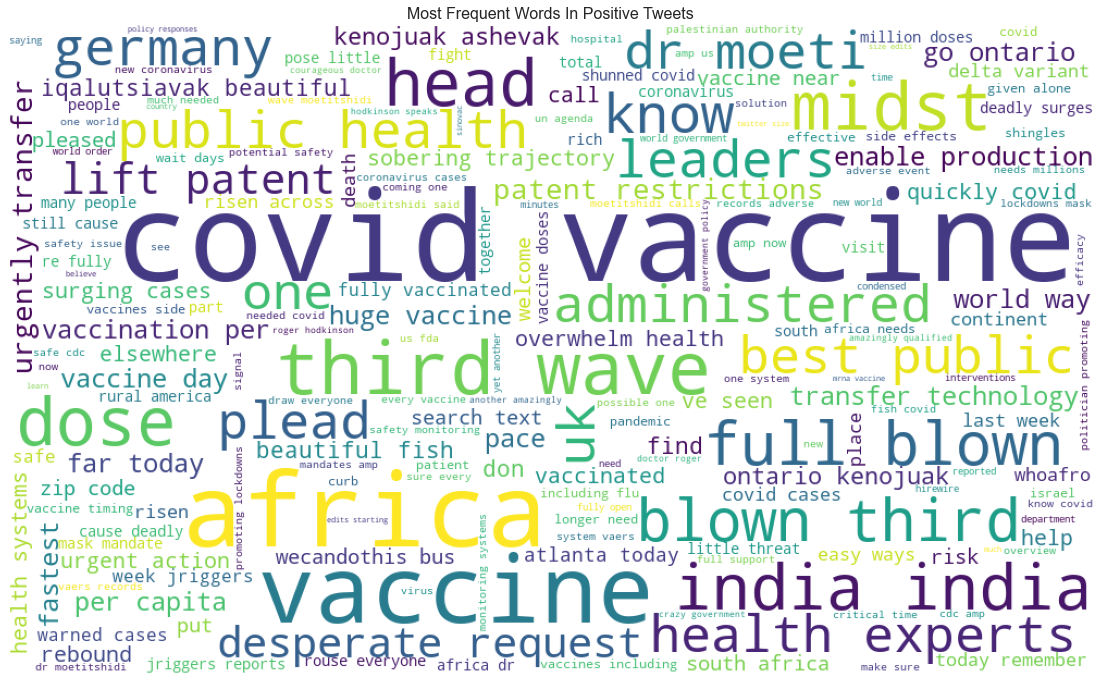

In [69]:
plt.figure(figsize=(20, 12))

plt.imshow(WordCloud(width=1000, height=600, background_color='white', stopwords=STOP_WORDS).generate(
    ' '.join(positive_tweets.clean_text .values)))
plt.axis('off')
plt.title('Most Frequent Words In Positive Tweets', fontsize=16)
plt.show()


### words cloud for negative tweets

In [70]:
negative_tweets = tweets[tweets['score'] == 'negative']

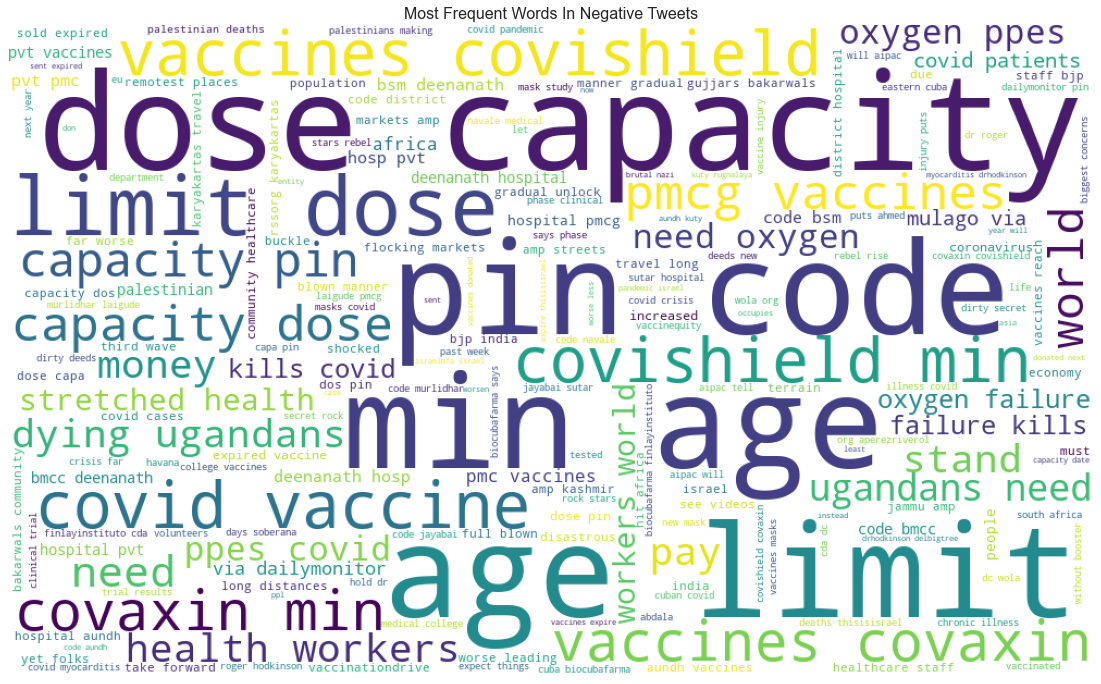

In [71]:
plt.figure(figsize=(20, 12))
plt.imshow(WordCloud(width=1000, height=600, background_color='white', stopwords=STOP_WORDS).generate(
    ' '.join(negative_tweets.clean_text.values)))
plt.axis('off')
plt.title('Most Frequent Words In Negative Tweets', fontsize=16)
plt.show()


### words cloud for neutral tweets

In [72]:
neutral_tweets = tweets[tweets['score'] == 'neutral']

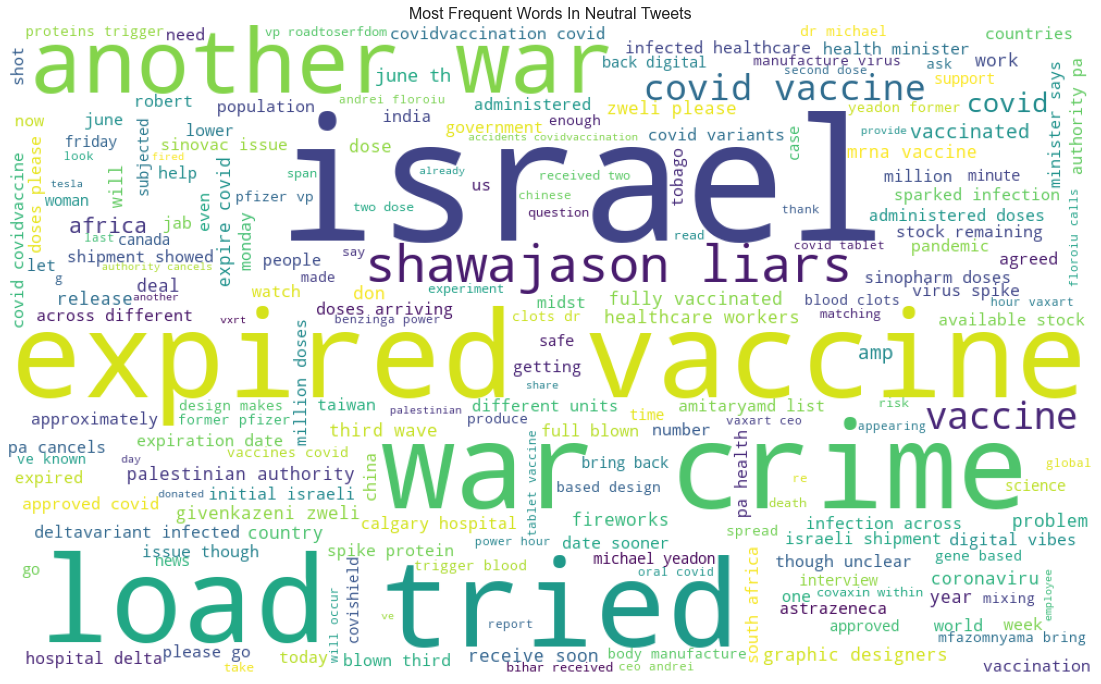

In [73]:
plt.figure(figsize=(20, 12))
plt.imshow(WordCloud(width=1000, height=600, background_color='white', stopwords=STOP_WORDS).generate(
    ' '.join(neutral_tweets.clean_text .values)))
plt.axis('off')
plt.title('Most Frequent Words In Neutral Tweets', fontsize=16)
plt.show()


### Word Cloud for all tweets

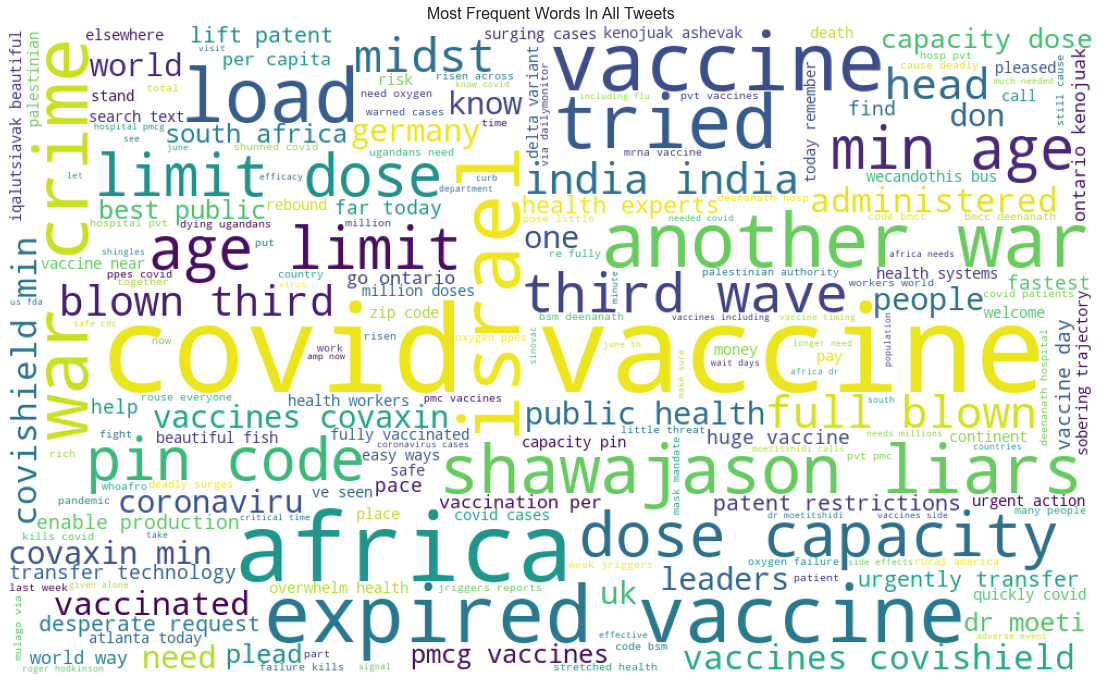

In [74]:
plt.figure(figsize=(20, 12))
plt.imshow(WordCloud(width=1000, height=600, background_color='white', stopwords=STOP_WORDS).generate(
    ' '.join(tweets.clean_text .values)))
plt.axis('off')
plt.title('Most Frequent Words In All Tweets', fontsize=16)
plt.show()
